In [1]:
from keras.layers import Input,Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from glob import glob
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
epochs = 30
batch_size = 128
train_path = '../input/official-leaf/train_aug'
img_files = glob(train_path + '/*/*.*') 
folders = glob(train_path + '/*')
len(folders)

39

In [3]:
vgg = VGG16(input_shape=(256,256,3),  weights='imagenet', include_top=False)
for layer in vgg.layers:
  layer.trainable = False

58892288/58889256 [==============================] - 2s 0us/step


In [4]:
x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [5]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [6]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input, 
                        validation_split=0.2,
                        horizontal_flip = True,
                        vertical_flip = True,
                        height_shift_range = 0.1,
                        width_shift_range = 0.1)
valid_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               validation_split = 0.2)


In [7]:
train_generator = train_gen.flow_from_directory(
    train_path,
    target_size = (256, 256),
    shuffle=True, 
    batch_size=batch_size,
    subset='training',
)
valid_generator = valid_gen.flow_from_directory(
    train_path,
    target_size = (256, 256), 
    shuffle=False,
    batch_size=batch_size,
    subset='validation',
)


Found 42536 images belonging to 39 classes.
Found 10628 images belonging to 39 classes.


In [8]:
model_save = ModelCheckpoint('./vgg_model_augment_confusion.h5',
                             save_best_only = True, 
                             save_weights_only = False,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 6, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)
history = model.fit(train_generator,
              validation_data=valid_generator,
              epochs=epochs,
              steps_per_epoch=train_generator.n//train_generator.batch_size,
              validation_steps = valid_generator.n//valid_generator.batch_size,
              callbacks = [model_save, early_stop, reduce_lr]
              )

Epoch 1/30
332/332 [==============================] - 892s 3s/step - loss: 6.2154 - accuracy: 0.7250 - val_loss: 2.6358 - val_accuracy: 0.8935

Epoch 00001: val_loss improved from inf to 2.63581, saving model to ./vgg_model_augment_confusion.h5
Epoch 2/30
332/332 [==============================] - 786s 2s/step - loss: 1.9723 - accuracy: 0.9099 - val_loss: 1.9877 - val_accuracy: 0.9285

Epoch 00002: val_loss improved from 2.63581 to 1.98771, saving model to ./vgg_model_augment_confusion.h5
Epoch 3/30
332/332 [==============================] - 757s 2s/step - loss: 1.8634 - accuracy: 0.9290 - val_loss: 2.1316 - val_accuracy: 0.9355

Epoch 00003: val_loss did not improve from 1.98771
Epoch 4/30
332/332 [==============================] - 788s 2s/step - loss: 1.6988 - accuracy: 0.9432 - val_loss: 2.4739 - val_accuracy: 0.9364

Epoch 00004: val_loss did not improve from 1.98771

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/30
332/332 [===============

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.


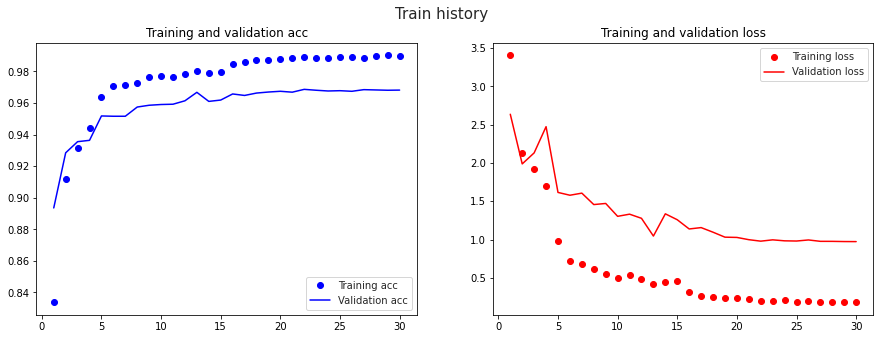

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, acc, "bo", label = "Training acc")
ax1.plot(epochs, val_acc, "b", label = "Validation acc")
ax1.set_title("Training and validation acc")
ax1.legend()

ax2.plot(epochs, loss, "bo", label = "Training loss", color = 'red')
ax2.plot(epochs, val_loss, "b", label = "Validation loss", color = 'red')
ax2.set_title("Training and validation loss")
ax2.legend()

plt.show()

In [10]:
valid_generator.reset()
Y_pred = model.predict(valid_generator, valid_generator.n // batch_size)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(valid_generator.classes, y_pred))
print('Classification Report')
target_names = ['Apple_scab',
                 'Apple_black_rot',
                 'Apple_cedar_apple_rust',
                 'Apple_healthy',
                 'Background_without_leaves',
                 'Blueberry_healthy',
                 'Cherry_powdery_mildew',
                 'Cherry_healthy',
                 'Corn_gray_leaf_spot',
                 'Corn_common_rust',
                 'Corn_northern_leaf_blight',
                 'Corn_healthy',
                 'Grape_black_rot',
                 'Grape_black_measles',
                 'Grape_leaf_blight',
                 'Grape_healthy',
                 'Orange_haunglongbing',
                 'Peach_bacterial_spot',
                 'Peach_healthy',
                 'Pepper_bacterial_spot',
                 'Pepper_healthy',
                 'Potato_early_blight',
                 'Potato_late_blight',
                 'Potato_healthy',
                 'Raspberry_healthy',
                 'Soybean_healthy',
                 'Squash_powdery_mildew',
                 'Strawberry_leaf_scorch',
                 'Strawberry_healthy',
                 'Tomato_bacterial_spot',
                 'Tomato_early_blight',
                 'Tomato_late_blight',
                 'Tomato_leaf_mold',
                 'Tomato_septoria_leaf_spot',
                 'Tomato_spider_mites_two-spotted_spider_mite',
                 'Tomato_target_spot',
                 'Tomato_yellow_leaf_curl_virus',
                 'Tomato_mosaic_virus',
                 'Tomato_healthy',
                 ]
print(classification_report(valid_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[194   1   0 ...   0   0   0]
 [  0 199   0 ...   0   0   0]
 [  0   0 195 ...   0   0   0]
 ...
 [  0   0   0 ... 843   0   0]
 [  0   0   0 ...   1 166   0]
 [  0   0   0 ...   0   0 247]]
Classification Report
                                             precision    recall  f1-score   support

                                 Apple_scab       0.98      0.97      0.98       200
                            Apple_black_rot       0.99      0.99      0.99       200
                     Apple_cedar_apple_rust       1.00      0.97      0.99       200
                              Apple_healthy       0.98      0.98      0.98       263
                  Background_without_leaves       1.00      0.95      0.97       182
                          Blueberry_healthy       1.00      1.00      1.00       240
                      Cherry_powdery_mildew       0.99      0.98      0.99       200
                             Cherry_healthy       0.99      0.98      0.99       200
   

In [11]:
mat = confusion_matrix(valid_generator.classes, y_pred)
type(mat)

numpy.ndarray

In [12]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True, 
                          size_mat=(40, 30)):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues
                  normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools
    import numpy as np

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=size_mat)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

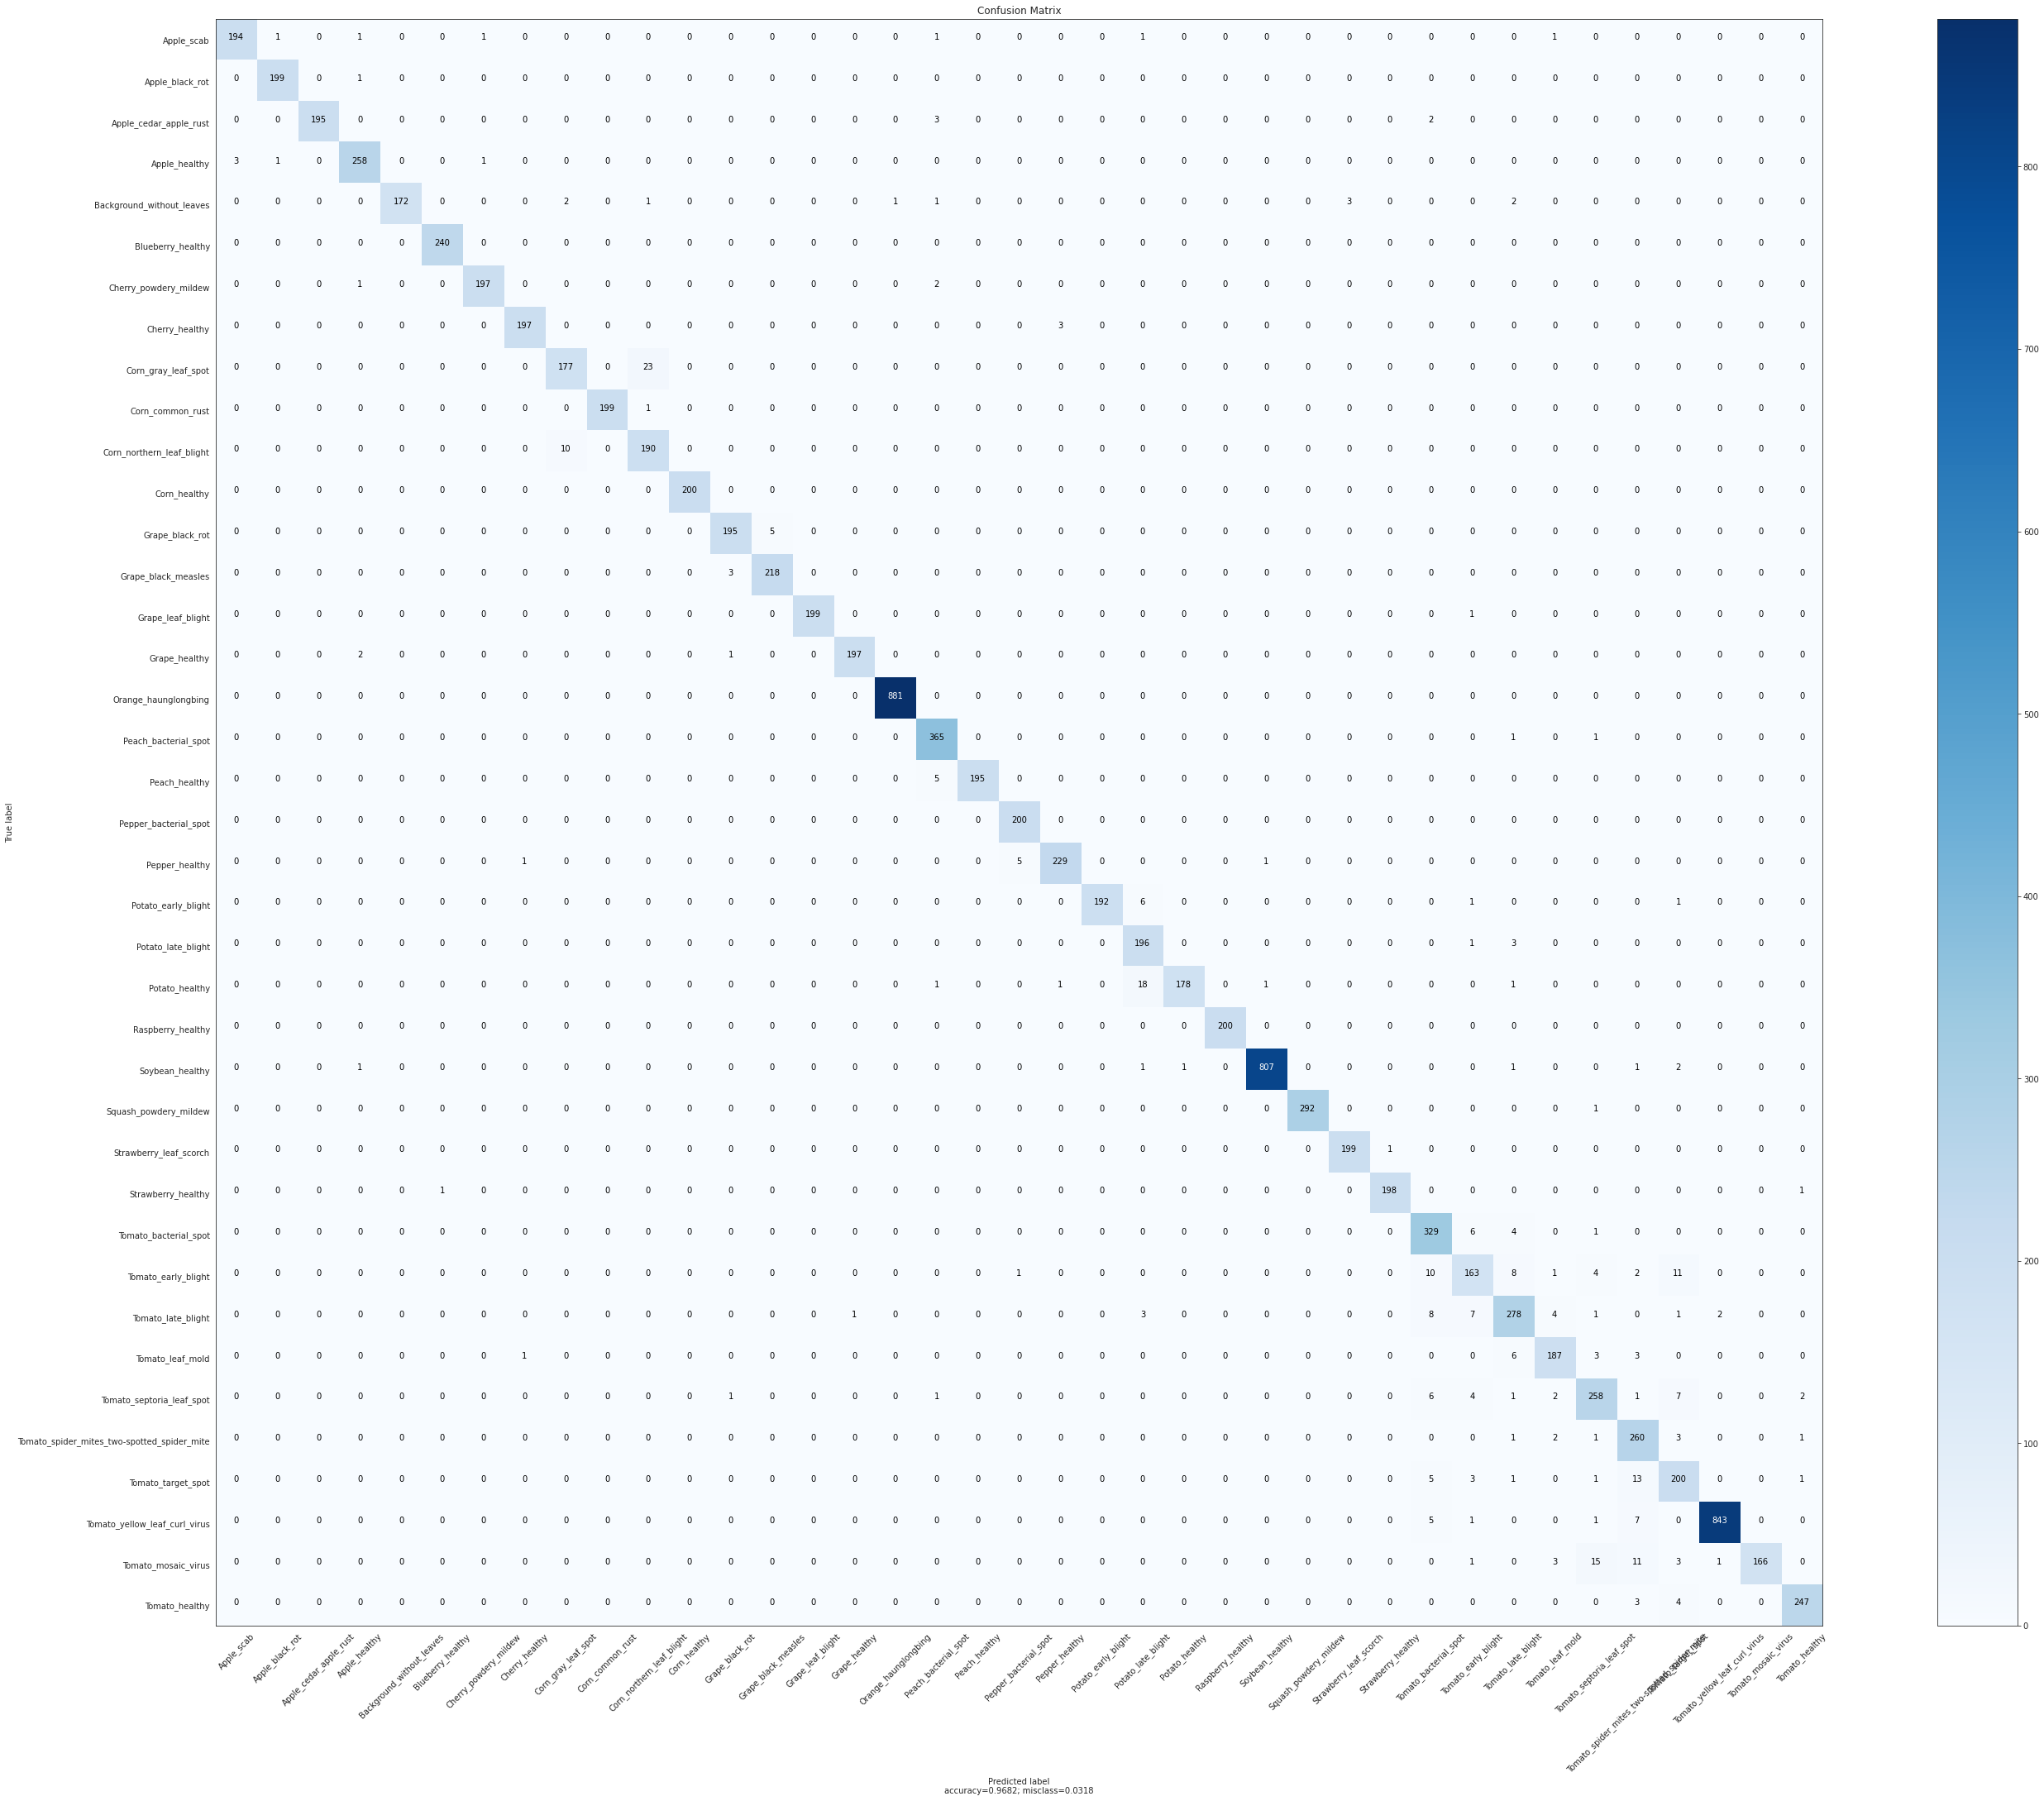

In [13]:
plot_confusion_matrix(cm           = mat,
                      normalize    = False,
                      target_names = target_names,
                      title        = "Confusion Matrix")

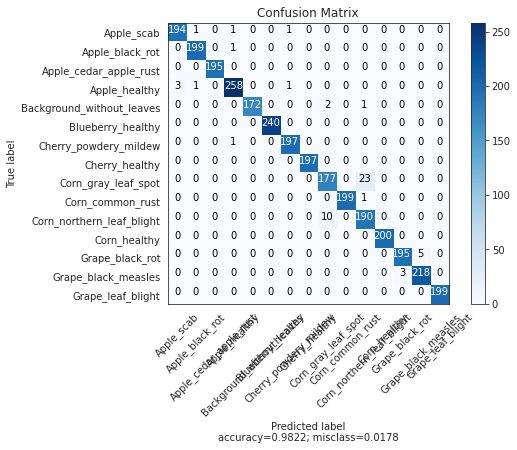

In [14]:
# plot a corner of the matrix
plot_confusion_matrix(cm           = mat[:15, :15],
                      normalize    = False,
                      target_names = target_names[:15],
                      title        = "Confusion Matrix",
                      size_mat = (8, 6))